In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize , basinhopping
from scipy.stats import poisson

In [6]:
header = ['trade_id','price','quantity','order_id','timestamp','is_buyer_maker']
df = pd.read_csv('./Data/BTCUSDT-trades-2023-05-26.csv',header=0 , names = header)
df.head()

,trade_id,price,quantity,order_id,timestamp,is_buyer_maker
0,3751246457,26461.7,0.041,1084.9297,1685059200171,True
1,3751246458,26461.7,0.359,9499.7503,1685059200171,True
2,3751246459,26461.8,0.003,79.3854,1685059200251,False
3,3751246460,26461.8,0.002,52.9236,1685059200371,False
4,3751246461,26461.8,0.008,211.6944,1685059200407,False


In [7]:
def closed_time_series(df, time_interval):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('timestamp')
    df['buy_quantity'] = np.where(df['is_buyer_maker'], df['quantity'], 0)
    df['sell_quantity'] = np.where(df['is_buyer_maker'], 0, df['quantity'])
    df = df.resample(str(time_interval)+'S').agg({'price':'last', 'quantity':'sum', 'buy_quantity':'sum', 'sell_quantity':'sum'})
    df['log_return'] = np.log(df['price']).diff()
    df = df.dropna()
    return df

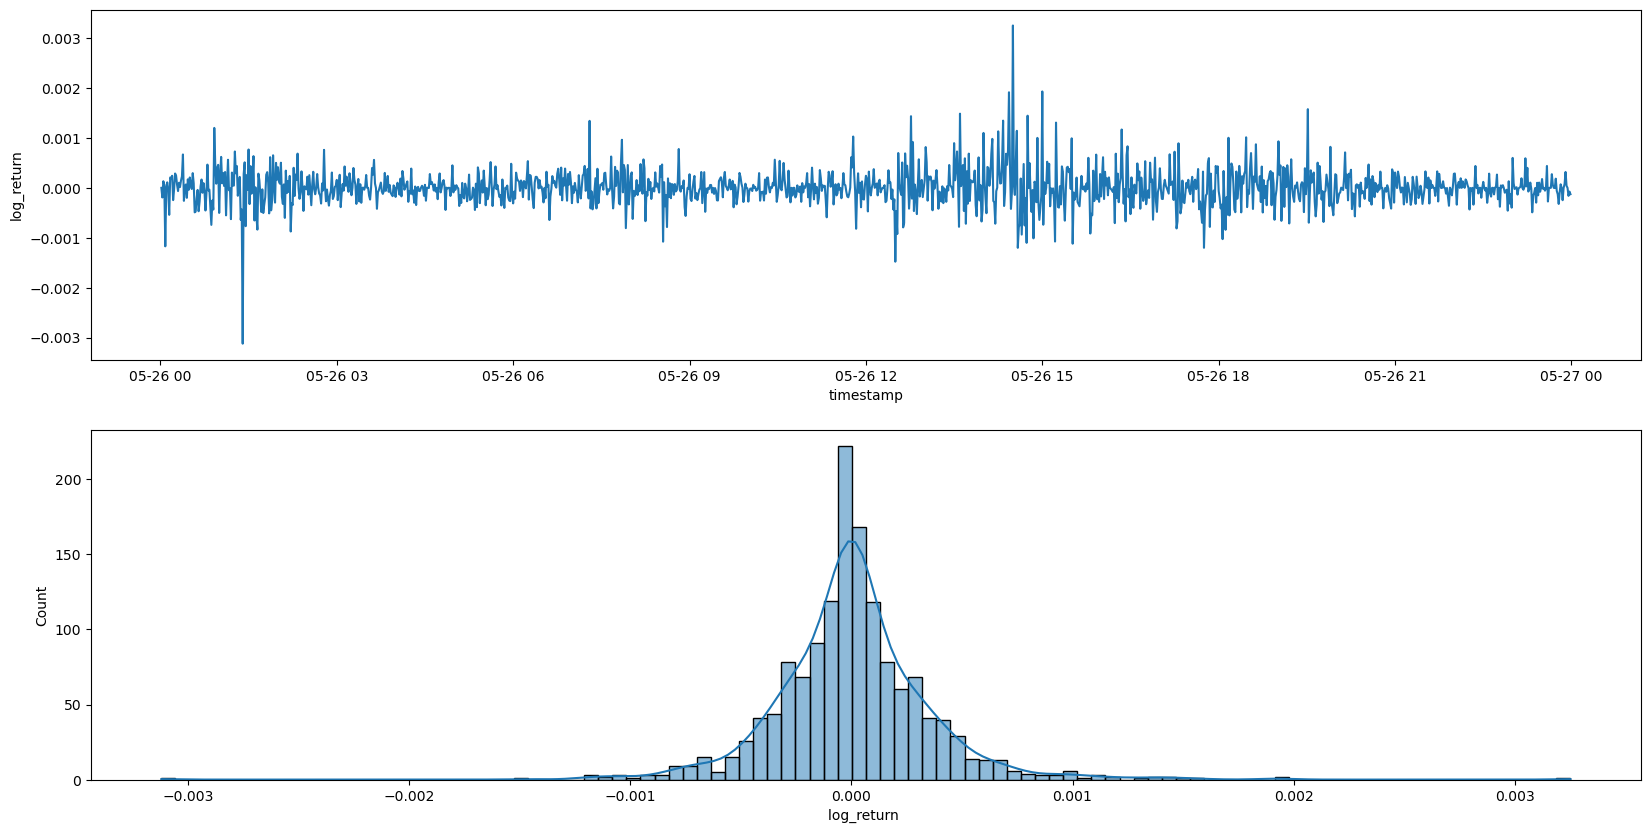

In [8]:
df_2 = closed_time_series(df, 60)
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(data=df_2, x=df_2.index, y='log_return', ax=axs[0])
sns.histplot(data=df_2, x='log_return', bins=100, ax=axs[1], kde=True)
axs[0].set_ylabel('log_return')
axs[1].set_xlabel('log_return ')
plt.show()

# 1. Probability of Execution 

## 1.1 Market Impact Model

The market impact model suggested by the Kyle.  The model is based on the following assumptions:   

$$ \Delta r = K ln(Q)$$ 

where $K$ is the market impact parameter, $Q$ is the order quantity during that time period $dt$ and $r_t$ is log return of the stock price.   

In [9]:
def market_impact(df,time):
    data = closed_time_series(df,time)
    data = data[data['quantity'] != 0] 
    qty = np.log(data['quantity'])
    a , b = np.polyfit(qty,np.abs(data['log_return']),1)
    return 1 / a

def buy_market_impact(df,time):
    data = closed_time_series(df,time)
    data = data.drop(data[data['log_return'] < 0].index)
    data = data[data['buy_quantity'] != 0]
    buy_qty = np.log(data['buy_quantity'])
    a , b = np.polyfit(buy_qty,data['log_return'],1)
    return 1 / a

def sell_market_impact(df,time):
    data = closed_time_series(df,time)
    data = data.drop(data[data['log_return'] > 0].index)
    data = data[data['sell_quantity'] != 0]
    sell_qty = np.log(data['sell_quantity'])
    a , b = np.polyfit(sell_qty,np.abs(data['log_return']),1)
    return 1 / a

In [10]:
total_market_impact = market_impact(df,60)
buy_market_impact = buy_market_impact(df,60)
sell_market_impact = sell_market_impact(df,60)

print('total_market_impact: ', total_market_impact)
print('buy_market_impact: ', buy_market_impact)
print('sell_market_impact: ', sell_market_impact)

total_market_impact:  6409.174724846925
buy_market_impact:  8861.907586120917
sell_market_impact:  11314.599048190134


In [11]:
def plot_market_impact(df, time):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Plot total market impact
    data = closed_time_series(df, time) 
    data = data[data['quantity'] != 0]
    total_qty = np.log(data['quantity'])
    a, b = np.polyfit(total_qty, np.abs(data['log_return']), 1)
    sns.scatterplot(data=data, x=total_qty, y=np.abs(data['log_return']), ax=ax1)
    sns.lineplot(x=total_qty, y=a*total_qty+b, color='red', ax=ax1)
    ax1.set_xlabel('log(quantity)')
    ax1.set_ylabel('log(return)')
    ax1.set_title('Total Market Impact')

    # Plot buy market impact
    data = closed_time_series(df, time)
    data = data.drop(data[data['log_return'] < 0].index)
    data = data[data['buy_quantity'] != 0]
    buy_qty = np.log(data['buy_quantity'])
    a, b = np.polyfit(buy_qty, data['log_return'], 1)
    sns.scatterplot(data=data, x=buy_qty, y=data['log_return'], ax=ax2)
    sns.lineplot(x=buy_qty, y=a*buy_qty+b, color='red', ax=ax2)
    ax2.set_xlabel('log(buy_quantity)')
    ax2.set_ylabel('log(return)')
    ax2.set_title('Buy Market Impact')

    # Plot sell market impact
    data = closed_time_series(df, time)
    data = data.drop(data[data['log_return'] > 0].index)
    data = data[data['sell_quantity'] != 0]
    sell_qty = np.log(data['sell_quantity'])
    a, b = np.polyfit(sell_qty, np.abs(data['log_return']), 1)
    sns.scatterplot(data=data, x=sell_qty, y=np.abs(data['log_return']), ax=ax3)
    sns.lineplot(x=sell_qty, y=a*sell_qty+b, color='red', ax=ax3)
    ax3.set_xlabel('log(sell_quantity)')
    ax3.set_ylabel('log(abs(return))')
    ax3.set_title('Sell Market Impact')

    plt.show()


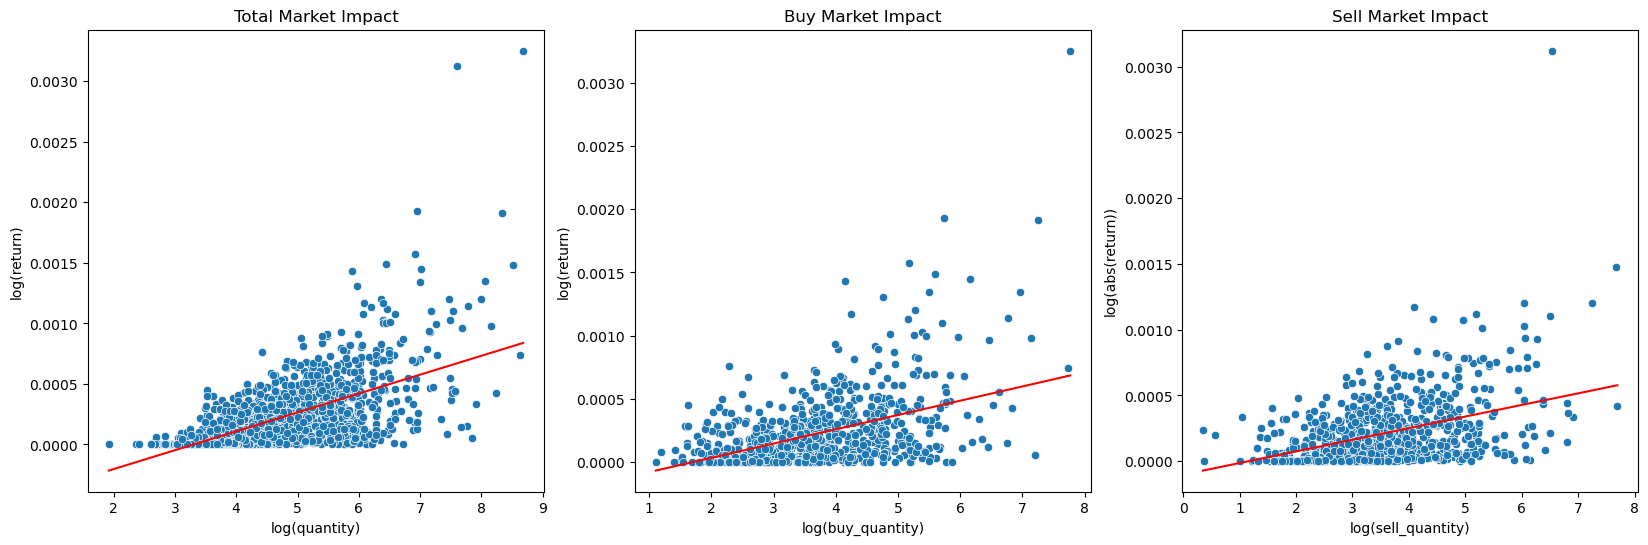

In [12]:
plot_market_impact(df, 60)

## 1.2 Market Order Distribution 

In the econophysics literture, the market order quantity is often assumed to follow a power law distribution.  
The power law distribution is defined as:  
$$ \mathbb {P(x)} \propto x^{-1 -\alpha}$$  
where $\alpha$ is the exponent of the power law distribution. But you have notice that the probability distribution function is not normalized.  
To normalize the distribution, we need to integrate the distribution function. The result is:  

$$ \mathbb {P(x)} = \frac{\alpha x_{\mathrm{m}}^\alpha}{x^{\alpha+1}}$$  
that is Pareto distribution.

In [10]:
def plot_qty_distributions(df):
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    # Plot sell quantity distribution
    sell_qty = df['sell_quantity']
    sns.histplot(data=sell_qty, ax=axs[0, 0],bins=500)
    axs[0, 0].set_xlabel('sell_quantity')
    axs[0, 0].set_ylabel('Count')
    axs[0, 0].set_title('Sell Quantity Distribution')

    # Plot buy quantity distribution
    buy_qty = df['buy_quantity']
    sns.histplot(data=buy_qty, ax=axs[0, 1], bins=500)
    axs[0, 1].set_xlabel('buy_quantity')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_title('Buy Quantity Distribution')

    # Plot total quantity distribution
    qty = df['quantity']
    sns.histplot(data=qty, ax=axs[0, 2], bins=500)
    axs[0, 2].set_xlabel('quantity')
    axs[0, 2].set_ylabel('Count')
    axs[0, 2].set_title('Total Quantity Distribution')

    # Plot kernel density estimation of total quantity
    sns.kdeplot(data=qty, ax=axs[1 , 0], fill=True)
    axs[1, 0].set_xlabel('quantity')
    axs[1, 0].set_ylabel('Density')
    axs[1, 0].set_title('Kernel Density Estimation of Total Quantity')

    # Plot kernel density estimation of sell quantity
    sns.kdeplot(data=sell_qty, ax=axs[1 , 1], fill=True)
    axs[1, 1].set_xlabel('sell_quantity')
    axs[1, 1].set_ylabel('Density')
    axs[1, 1].set_title('Kernel Density Estimation of Sell Quantity')

    # Plot kernel density estimation of buy quantity
    sns.kdeplot(data=buy_qty, ax=axs[1 , 2], fill=True)
    axs[1, 2].set_xlabel('buy_quantity')
    axs[1, 2].set_ylabel('Density')
    axs[1, 2].set_title('Kernel Density Estimation of Buy Quantity')

    plt.show()


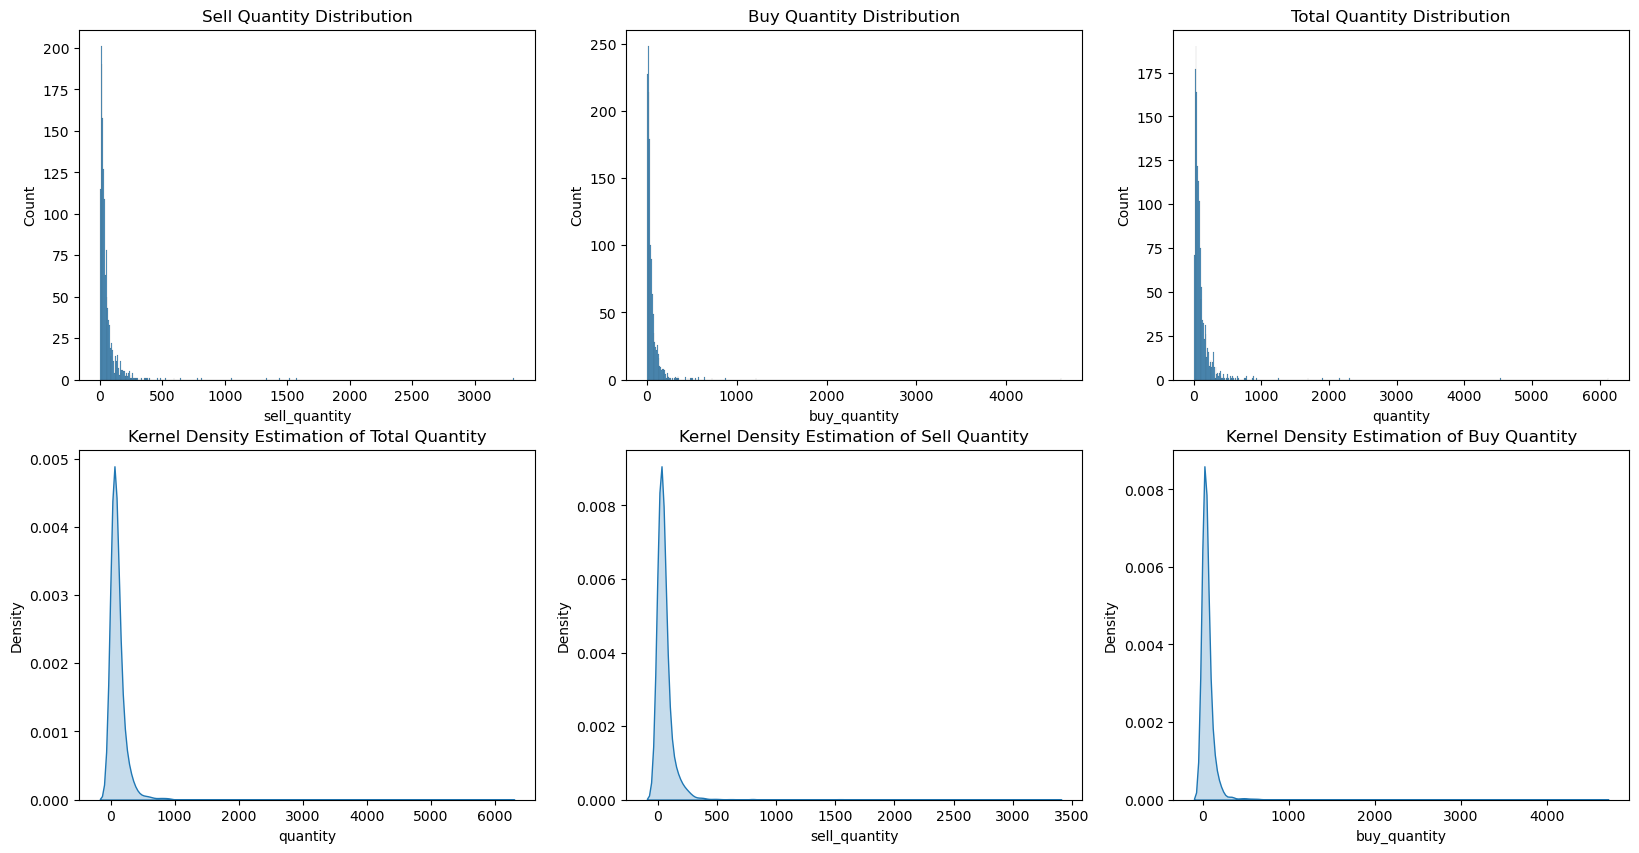

In [11]:
plot_qty_distributions(df_2)

In [12]:
def maximum_likelihood_alpha(quantity,MIN_ORDER):
    N = len(quantity)
    log_mean = np.sum(np.log(quantity / MIN_ORDER))
    alpha_hat = N / log_mean
    return alpha_hat

In [13]:
alpha_hat_buy = maximum_likelihood_alpha(df_2['buy_quantity'],1)
print("alpha: ",alpha_hat_buy)

alpha_hat_sell = maximum_likelihood_alpha(df_2['sell_quantity'],1)
print("alpha: ",alpha_hat_sell)

alpha:  0.2924048842188008
alpha:  0.2916066623839556


## 1.3 Probability of Execution

Now we can calculate the probability of execution of market making agent's limit order(LO).   
Let us assume that LO is executed if mid-price moves over her LO. It can be expressed as:  $ \mathbb {P(\Delta r > \delta)}$   


Then using the market impact model, we can rewrite the probability of execution as:
$$\begin{aligned}
\lambda(\delta) & =\Lambda P(\Delta p>\delta) \\
& =\Lambda P(\ln (Q)>K \delta) \\
& =\Lambda P(Q>\exp (K \delta)) \\
& =\Lambda \alpha x_{min}^{\alpha}\int_{\exp (K \delta)}^{\infty} x^{-1-\alpha} \mathrm{d} x \\
& =A \exp (-k \delta)
\end{aligned} $$
where $A = \Lambda  x_{min}^{\alpha}$ and $k = \alpha  K$ and $\Lambda$ is market order frequency of buy or sell .



In [14]:
def market_order_frequency(data):
    all_market_order = data['quantity'].sum()/data['quantity'].mean()
    return all_market_order

def intensity_lambda(A,k,delta):
    return A * np.exp(- k * delta)

def plot_intensity_lambda(data, MIN_ORDER):
    deltas = np.linspace(0, 0.001, 1000)
    freq = market_order_frequency(data) / 2
    alpha = maximum_likelihood_alpha(data['quantity'], MIN_ORDER)
    k = alpha * market_impact(data, 60)
    A = freq * (MIN_ORDER ** alpha)
    intensities = [intensity_lambda(A, k, delta) for delta in deltas]

    df = pd.DataFrame({'delta': deltas, 'intensity': intensities})

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(x='delta', y='intensity', data=df, ax=ax)
    ax.set_xlabel('delta')
    ax.set_ylabel('Intensity lambda')
    ax.set_title('Intensity Lambda vs Delta')
    plt.show()

In [15]:
plot_intensity_lambda(df_2,0.1)

KeyError: 'timestamp'

# 2. Parameter Estimation of Mid-price model

## 2.1 Geometric Brownian Motion

Geometric Brownian Motion (GBM) is a stochastic process that describes the evolution of a stock price.   
The log return of the stock at time $t$ is given by the following equation
$$\frac{dS_t}{S_t} = \mu dt + \sigma dW_t$$
Then we can solve SDE to get the stock price at time $t$:
$$S_t = S_0 \exp \left( \left( \mu - \frac{\sigma^2}{2} \right) t + \sigma W_t \right)$$
Let $Y_t = log(S_t / S_0)$, then $Y_t$ follows a normal distribution:
$$ Y_T \sim \mathcal{N}((\mu - \frac{\sigma^2}{2})t,\sigma^2t)$$
where $S_0$ is the initial stock price, $\mu$ is the drift, $\sigma$ is the volatility, and $W_t$ is a standard Brownian motion. The drift and volatility are constant parameters.   

In [16]:
def mle_mu(data):
    mu = data['log_return'].mean() / (1/1440)
    return mu

def mle_sigma(data):
    sigma = data['log_return'].std() / np.sqrt(1/1440)
    return sigma

In [17]:
data = closed_time_series(df,60)
mu_hat = mle_mu(data)
sigma_hat = mle_sigma(data)
print(f"mu: {mu_hat}", f"sigma: {sigma_hat}")

mu: 0.005113149113887727 sigma: 0.009780735282924807


In [18]:
# draw the stock path and distribution
def gbmsim(S0, mu, sigma,T,N):
    dt = T / N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)# standard brownian motion
    X = (mu - 0.5 * sigma ** 2) * t + sigma * W # geometric brownian motion
    S = S0 * np.exp(X) # lognormal distribution
    return S

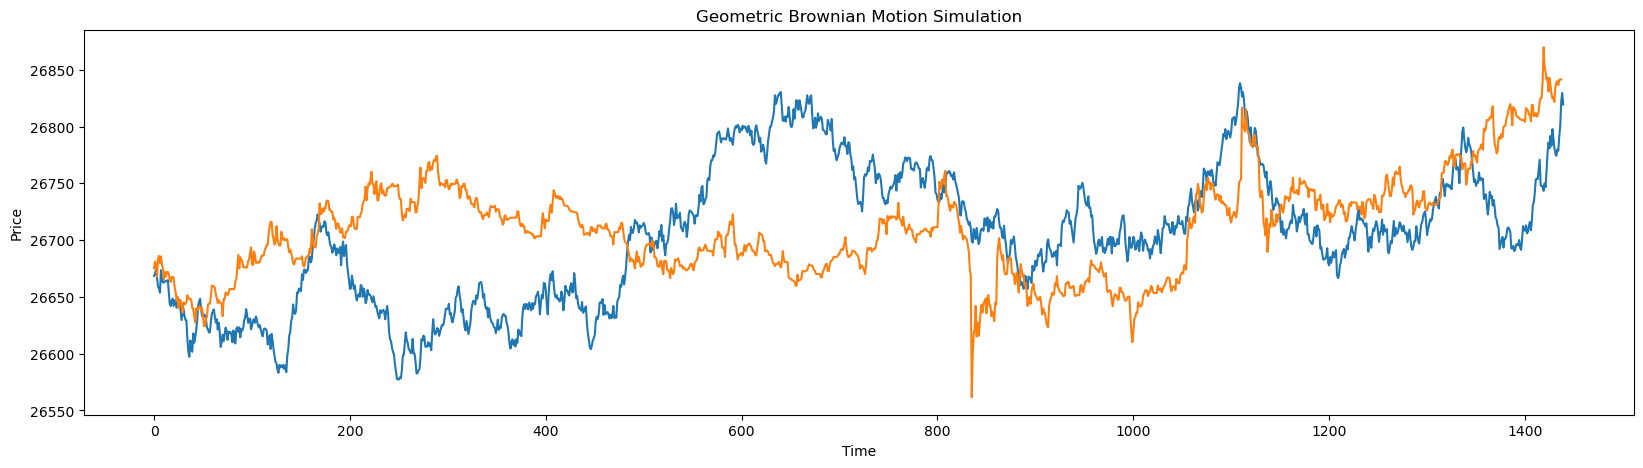

In [20]:
s = gbmsim(data['price'][0],mu_hat,sigma_hat,1,1440)
plt.figure(figsize=(20,5))
plt.plot(s)
plt.plot(np.array(df_2['price'][1:]))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Geometric Brownian Motion Simulation')
plt.show()

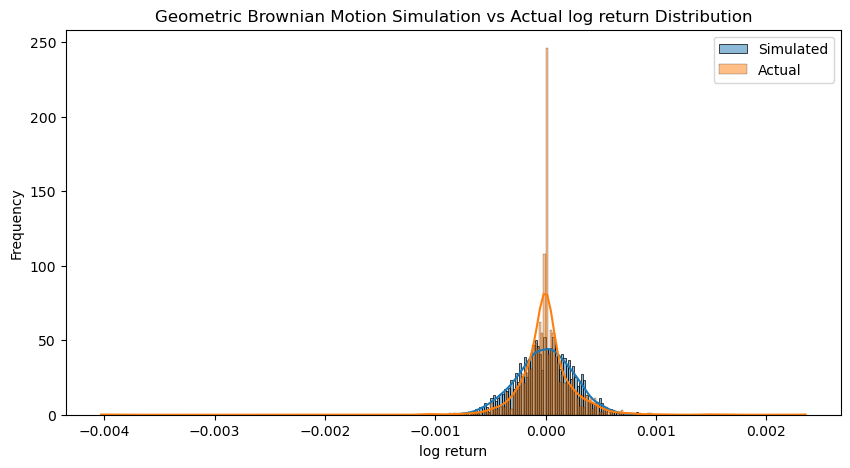

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(np.log(s[:-1]/s[1:]),bins = 100,binrange = (-0.001,0.001),label='Simulated',kde=True)
sns.histplot(df_2['log_return'],bins=100,binrange = (-0.001,0.001), label='Actual',kde=True)

plt.legend(loc='upper right')
plt.xlabel('log return')
plt.ylabel('Frequency')
plt.title('Geometric Brownian Motion Simulation vs Actual log return Distribution')
plt.show()

## 2.2 Merton's jump diffusion 

In real world, the distribution of log return is not really normal.   
It is more likely to have a fat tail.  

Geometric Brownian Motion with jump diffusion follows SDE below:  
$$\frac{dS_t}{S_t} = \mu dt + \sigma dW_t + \xi dN_{t}^a - \xi dN_{t}^b$$   
where $\xi \gt 0$ and $dN_{t}^a$ is the number of jumps that occur in the interval $(t, t+dt)$.  
The jump size can be interpreted as adverse selection.

Let's solve the closed form solution of Merton's jump diffusion.
Assume that the jump size is log-normally distributed with mean $\mu_j$ and variance $\sigma_j^2$.
Thus relative jump size is 
$$ \frac{dS_t}{S_t} = \frac{(y_t S_t - S_t)}{S_t} = y_t - 1$$
where $y_t$ is the jump size.  
Then we can rewrite the SDE as:

$$ \frac{dS_t}{S_t} = \mu dt + \sigma dW_t + (y_{t} - 1) dN_{t}^a $$ 
By the Ito lemma of jump diffusion process, 
###
$$S_t = S_0 \exp \left( \left( \mu - \frac{\sigma^2}{2} \right) t + \sigma W_t + \sum_{i=1}^{N_t} J_i \right)$$

where $J_i$ is the jump size at time $t_i$ and $N_t$ is the number of jumps that occur in the interval $(0, t)$.

### MLE of Merton's jump diffusion
Let $x_t = ln(S_t/S_0)$, then by the total law of probability, 
$$ \mathbb{P}(x \in A) = \sum_{i=0}^{\infin} \mathbb{P}(x \in A | N_t = i) \mathbb{P}(N_t = i)$$
where $A$ is an arbitrary set of real numbers.  
Then we can get the log-likelihood function of Merton's jump diffusion:
$$ l(\mu,\sigma,\mu_{j},\sigma_{j},\lambda_{j},x) = \sum_{t=0}^{T} ln(\sum_{i=0}^{N_t} \frac{e^{\lambda_{j} dt} (\lambda_{j}dt)^{i}}{i!} \frac{1}{\sqrt{2 \pi (\sigma^2 dt + i\sigma_{j}^2)}}exp(- \frac{(x - \mu dt - i \mu_{j})^2}{2 (\sigma^2 dt+ i\sigma_{j}^2)}))$$
However, the log-likelihood function is not convex. So we can not use gradient descent to find the optimal parameters.


In [21]:
def jump_diffusion_sim(S_0, mu, sigma, mu_jump, sigma_jump, lambda_jump, T, N):
    dt = T / N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # standard brownian motion
    J = np.cumsum(np.random.normal(mu_jump * dt, sigma_jump**2, size=N) 
        * np.random.poisson(lambda_jump * dt, N))  # jump process
    X = (mu - 0.5 * sigma ** 2) * t + sigma * W + J  # geometric brownian motion
    S = S_0 * np.exp(X)  # log normal distribution
    return S

def mle_jump_diffusion(param, data):
    mu = param[0]
    volatility = param[1]
    jump_drift = param[2]
    jump_volatility = param[3]
    jump_intensity = param[4]

    dt = 1 / 1440
    likelihood = []
    for t in range(0, len(data)):
        sum_i = 0
        for i in range(0, 100):
            sum_i += (
                np.exp(-jump_intensity * dt) * ((jump_intensity * dt) ** i / np.math.factorial(i))
                * (1 / np.sqrt(2 * np.pi * (volatility ** 2 * dt + i * jump_volatility ** 2)))
                * np.exp(- (data[t] - mu * dt - i * jump_drift) ** 2 / (2 * ((volatility ** 2 * dt + i * jump_volatility ** 2)))))
        if sum_i == 0:
            likelihood.append(1e-100)
        else:
            likelihood.append(sum_i)
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

def mle_jump_diffusion2(param, data):
    mu = param[0]
    volatility = param[1]
    jump_drift = param[2]
    jump_volatility = param[3]
    jump_intensity = param[4]

    dt = 1 / 1440
    likelihood = np.zeros(len(data))
    for i in range(0, 100):
        sum_i = np.exp(-jump_intensity * dt) * ((jump_intensity * dt) ** i / np.math.factorial(i))
        sum_i *= (1 / np.sqrt(2 * np.pi * (volatility ** 2 * dt + i * jump_volatility ** 2)))
        sum_i *= np.exp(- (data - mu * dt - i * jump_drift) ** 2 / (2 * ((volatility ** 2 * dt + i * jump_volatility ** 2))))
        likelihood += sum_i

    likelihood[likelihood == 0] = 1e-100
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood


In [ ]:
mu_0 = mle_mu(data) 
sigma_0 = mle_sigma(data)

mu_jump_0 = mu_0
sigma_jump_0 = sigma_0
lambda_jump_0 = 10
args = np.array((data['log_return'])) * 10000 #size of the log return is too small, so we multiply it by 10000

param = [mu_0,sigma_0,mu_jump_0,sigma_jump_0,lambda_jump_0]
bounds = ((-np.inf,np.inf),(0.0001,np.inf),(-np.inf,np.inf),(0.0001,np.inf),(1,np.inf))
res_lbfgsb = minimize(mle_jump_diffusion, param, args = args,bounds=bounds,method='L-BFGS-B')

print('l-bfgs-b',res_lbfgsb.x)

In [34]:
res_basin = basinhopping(mle_jump_diffusion2, param, minimizer_kwargs={"args": args},niter=100)
res_basin.x

/var/folders/tc/pk8_r5g56wx6w90jrt_973rc0000gn/T/ipykernel_70817/3379449570.py:51: RuntimeWarning: invalid value encountered in log
  log_likelihood = np.sum(np.log(likelihood))


array([ 338.24197055, -152.29971586,  -15.74506019,    1.5350306 ,
         11.27125235])

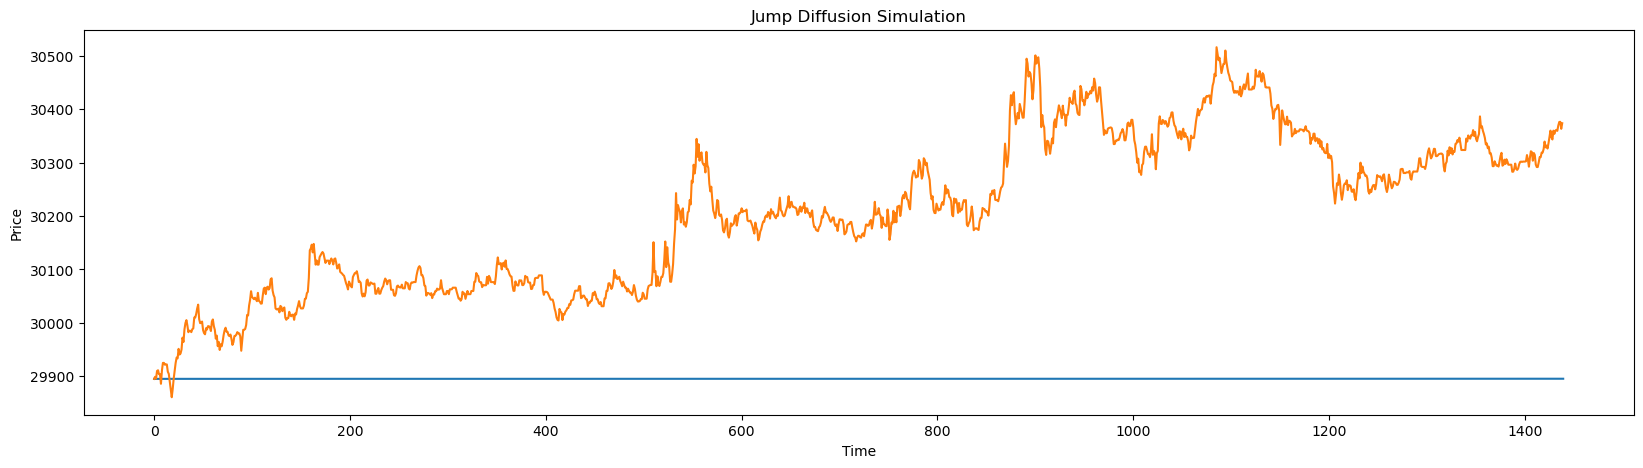

In [55]:
res = res_lbfgsb
mu_hat = res.x[0] / 10000
sigma_hat = res.x[1] / 10000
mu_jump_hat = res.x[2] / 10000
sigma_jump_hat = res.x[3] / 10000
lambda_jump_hat = res.x[4]

path = jump_diffusion_sim(df_2['price'][0],mu_hat,sigma_hat,mu_jump_hat,sigma_jump_hat,lambda_jump_hat,1,1440)
plt.figure(figsize=(20,5))
plt.plot(path)
plt.plot(np.array(df_2['price']))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Jump Diffusion Simulation')
plt.show()

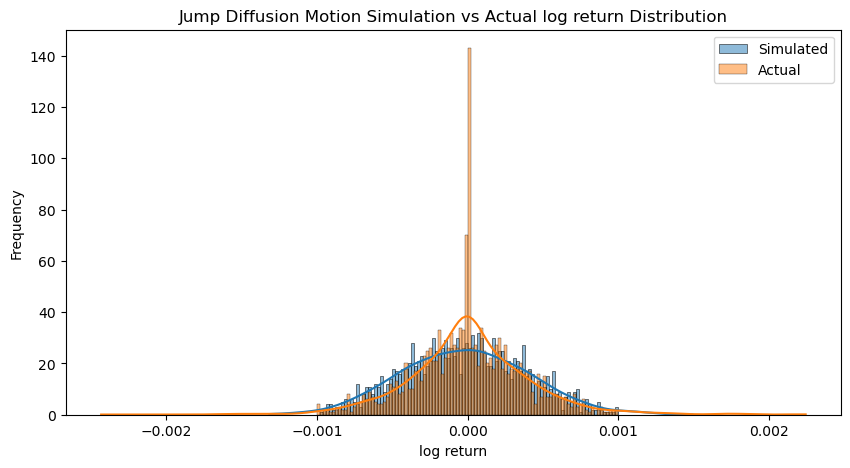

In [44]:
plt.figure(figsize=(10,5))
sns.histplot(np.log(path[:-1]/path[1:]),bins=100,binrange=(-0.001,0.001),label='Simulated',kde=True)
sns.histplot(df_2['log_return'],bins=100,binrange=(-0.001,0.001),label='Actual',kde=True)

plt.legend(loc='upper right')
plt.xlabel('log return')
plt.ylabel('Frequency')
plt.title('Jump Diffusion Motion Simulation vs Actual log return Distribution')
plt.show()

# 3. Optimal Market Making Strategy

The inventory of the market maker is the difference between the number of buy orders and the number of sell orders. i.e ) 
$$q_t = \Delta N_t^b - \Delta N_t^a$$  
where $N_t^{a}$ and $N_t^{b}$ are point processes and $\Delta$ is number of order quantity.

Since our model is dimensionless GBM. Thus, cash process is given by the following equation:  
$$d X_t=S_t \left(1 + \delta_t^a- \epsilon \right ) \Delta dN_t^a- S_t \left(1- \delta_t^b+ \epsilon \right)\Delta  d N_t^b$$   
where $\epsilon$ is the trading fee.
Our goal is to find the maximize objective function below: 
$$\sup _{\left(\delta_t^a\right)_t,\left(\delta_t^b\right)_t \in \mathcal{A}} \mathbb{E}\left[-\exp \left(-\gamma\left(X_T+q_T S_T\right)\right)\right]$$
where $\gamma$ is the risk aversion parameter in CARA utility function , $\mathcal{A}$ is set of predictable processes bounded from below,.


## 3.1 HJB Equation

The HJB equation is given by the following equation:

$$ \partial t U + sup(\mathcal{L} U + F) = 0$$
where $\mathcal{L}$ is the infinitesimal generator of the process and $F$ is the running cost function.

The infinitesimal generator of the process is given by the following equation:
$$\mathcal{L} U = \frac{1}{2} \sigma^2 \partial_{s s}^2 U + \sup _{\delta^b} \lambda^b\left(\delta^b\right)\left[U\left(t, x-s+\delta^b, q+1, s\right)-U(t, x, q, s)\right] + \sup _{\delta^a} \lambda^a\left(\delta^a\right)\left[U\left(t, x+s+\delta^a, q-1, s\right)-U(t, x, q, s)\right]$$
where $\lambda^b$ and $\lambda^a$ are the intensity of the point process of buy and sell orders.

For $|q|<Q$ :
$$
\begin{gathered}
\partial_t u(t, x, q, s)+\frac{1}{2} \sigma^2 \partial_{s s}^2 u(t, x, q, s) \\
+\sup _{\delta^b} \lambda^b\left(\delta^b\right)\left[u\left(t, x-s+\delta^b, q+1, s\right)-u(t, x, q, s)\right] \\
+\sup _{\delta^a} \lambda^a\left(\delta^a\right)\left[u\left(t, x+s+\delta^a, q-1, s\right)-u(t, x, q, s)\right]=0
\end{gathered}
$$
For $q=Q$ :
$$
\begin{gathered}
\partial_t u(t, x, Q, s)+\frac{1}{2} \sigma^2 \partial_{s s}^2 u(t, x, Q, s) \\
+\sup _{\delta^a} \lambda^a\left(\delta^a\right)\left[u\left(t, x+s+\delta^a, Q-1, s\right)-u(t, x, Q, s)\right]=0
\end{gathered}
$$
For $q=-Q$ :
$$
\begin{gathered}
\partial_t u(t, x,-Q, s)+\frac{1}{2} \sigma^2 \partial_{s s}^2 u(t, x,-Q, s) \\
+\sup _{\delta^b} \lambda^b\left(\delta^b\right)\left[u\left(t, x-s+\delta^b,-Q+1, s\right)-u(t, x,-Q, s)\right]=0
\end{gathered}
$$
with the final condition:
$$
\forall q \in\{-Q, \ldots, Q\}, \quad u(T, x, q, s)=-\exp (-\gamma(x+q s))
$$

the solution of the HJB equation is given by the following equation:
$$ u(t, x, q, s)=\mathbb{E}\left[-\exp \left(-\gamma\left(X_T+q_T S_T\right)\right) | X_t=x, q_t=q, S_t=s\right]$$

## 3.2 Solution of HJB Equation

/var/folders/tc/pk8_r5g56wx6w90jrt_973rc0000gn/T/ipykernel_10278/4096070565.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


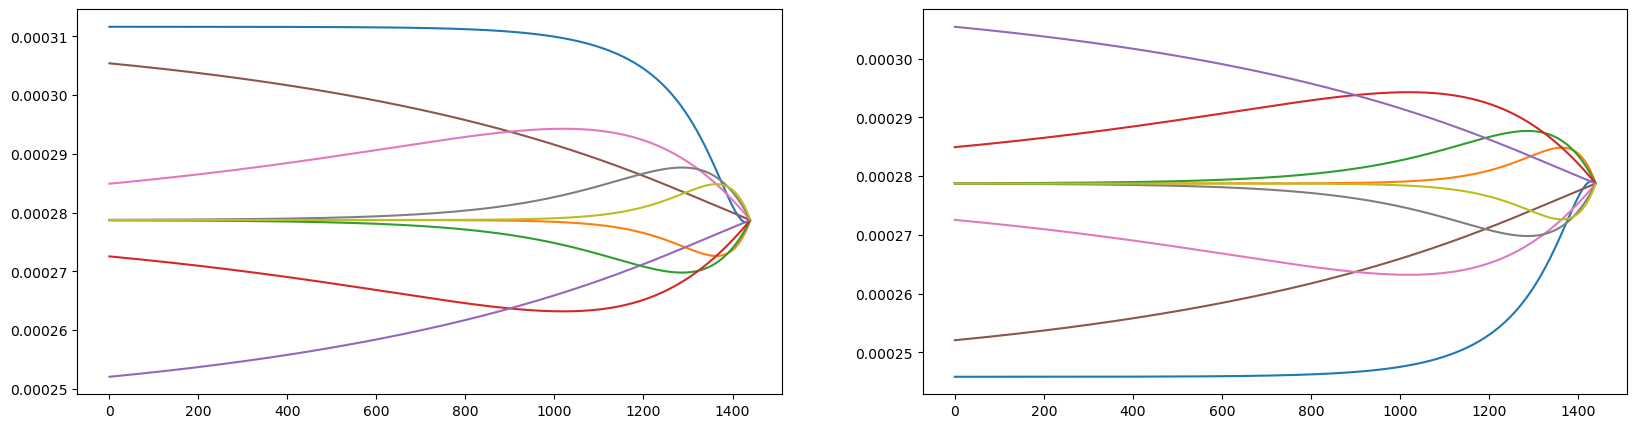

In [22]:
def create_matrix(Q, k, gamma, sigma, A, T, t):
    alpha = k/2 * gamma * sigma**2
    eta = A * (1 + gamma/k)**(-1 - k/gamma)
    diag = [alpha * q**2 for q in range(-Q, Q+1)]
    off_diag = [eta] * (2*Q)
    a = np.diag(diag, k=0)
    l = np.diag(off_diag, k=1)
    k = np.diag(off_diag, k=-1)
    M = a + l + k
    return np.exp(-M*(T-t))


def calculate_v(Q, k, gamma, sigma, A, T, t):
    vec = np.ones(2*Q+1).T
    M = create_matrix(Q, k, gamma, sigma, A, T, t)
    v = np.dot(M, vec)
    return v 


def calculate_delta_star(Q, k, gamma, sigma, A, T):
    delta_b_star = []
    delta_a_star = []
    for t in np.arange(0, T, 1/1440):
        v = calculate_v(Q, k, gamma, sigma, A, T, t)
        delta_b_star.append([np.log(v[q]/v[q+1])/k + np.log(1+gamma/k)/gamma for q in range(0, 2*Q -1)])
        delta_a_star.append([np.log(v[q]/v[q-1])/k + np.log(1+gamma/k)/gamma for q in range(1, 2*Q)])
    return np.array(delta_b_star), np.array(delta_a_star)

Q = 5
MIN_ORDER = 0.001
gamma = 10
A = alpha_hat_buy * (MIN_ORDER**alpha_hat_buy) * market_order_frequency(data)/2
k = alpha_hat_buy * (sell_market_impact + buy_market_impact)/2
T = 1.0
t = 0.0

delta_b_star, delta_a_star = calculate_delta_star(Q, k, gamma, sigma_hat, A, T)
fig, ax = plt.subplots(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(delta_b_star)
plt.subplot(1, 2, 2)
plt.plot(delta_a_star)
plt.show()

In [23]:
print(A,k)

27.91263060979332 3582.514838684346


References 
1. https://arxiv.org/pdf/1105.3115.pdf